In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.io.wavfile import write

In [2]:
def nndsvd_initialization(a, rank):

    u, s, v = np.linalg.svd(a, full_matrices=False)
    v = v.T
    w = np.zeros((a.shape[0], rank))
    h = np.zeros((rank, a.shape[1]))

    w[:, 0] = np.sqrt(s[0]) * np.abs(u[:, 0])
    h[0, :] = np.sqrt(s[0]) * np.abs(v[:, 0].T)

    for i in range(1, rank):
        ui = u[:, i]
        vi = v[:, i]
        ui_pos = (ui >= 0) * ui
        ui_neg = (ui < 0) * -ui
        vi_pos = (vi >= 0) * vi
        vi_neg = (vi < 0) * -vi

        ui_pos_norm = np.linalg.norm(ui_pos, 2)
        ui_neg_norm = np.linalg.norm(ui_neg, 2)
        vi_pos_norm = np.linalg.norm(vi_pos, 2)
        vi_neg_norm = np.linalg.norm(vi_neg, 2)

        norm_pos = ui_pos_norm * vi_pos_norm
        norm_neg = ui_neg_norm * vi_neg_norm

        if norm_pos >= norm_neg:
            w[:, i] = np.sqrt(s[i] * norm_pos) / ui_pos_norm * ui_pos
            h[i, :] = np.sqrt(s[i] * norm_pos) / vi_pos_norm * vi_pos.T
        else:
            w[:, i] = np.sqrt(s[i] * norm_neg) / ui_neg_norm * ui_neg
            h[i, :] = np.sqrt(s[i] * norm_neg) / vi_neg_norm * vi_neg.T

    return w, h



def divergence(V,W,H):
    return 1/2*np.linalg.norm(W@H-V)


def NMF(V, S, MAXITER = 5000, threshold = 1e-12): 

    counter = 0
    cost_function = []
    beta_divergence = 1
    
    W, H = nndsvd_initialization(V, S)

    while beta_divergence >= threshold and counter <= MAXITER:
        
        H *= (W.T @ V) / (W.T @ (W @ H) + 10e-10)
        H[H < 0] = 0
        W *= (V @ H.T) / ((W @ H) @ H.T + 10e-10)
        W[W < 0] = 0
        
        beta_divergence =  divergence(V, W, H)
        cost_function.append(beta_divergence)
        counter += 1

    return W, H, cost_function


In [3]:
FRAME1 = 1024
HOP = 512

In [4]:
audio_file = "../data/sound1_mix.mp3"
y, sr = librosa.load(audio_file)
D = librosa.stft(y, n_fft=FRAME1, hop_length=HOP)
magnitude = np.abs(D) 
ipd.Audio(y, rate = sr)

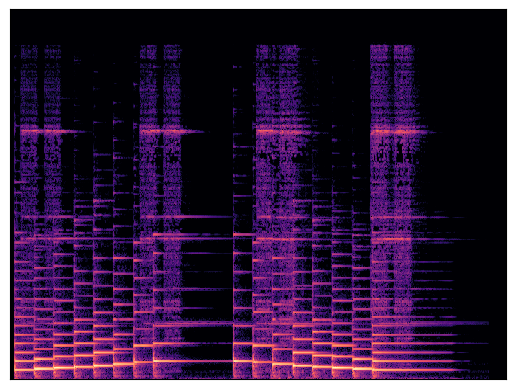

In [5]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude), sr=sr, n_fft=FRAME1, hop_length=HOP)

In [6]:
channels = 8
W, H, cost_func = NMF(magnitude, channels, MAXITER = 10000)

[80.16882238762128, 65.69627652317317, 58.251524550974004, 53.605910954577446, 50.05588655033485, 46.99139023661875, 44.435139125801506, 42.64828637158054, 41.60805097046823, 41.049205976789025, 40.74394417308941, 40.5680179115878, 40.46131930571442, 40.39379458186389, 40.349225097738525, 40.31850429671679, 40.29650428956924, 40.28027923071669, 40.26801845432347, 40.25853935019423, 40.25105754949396, 40.24504792600957, 40.240149228382556, 40.23610438091486, 40.232725388456785, 40.229872190351685, 40.22743885606516, 40.22534400229399, 40.22352416879357, 40.22192940403274, 40.22052029995207, 40.21926585986753, 40.218141894978885, 40.21712980944945, 40.21621560673933, 40.21538891338653, 40.214641887915256, 40.21396805089766, 40.21336124601601, 40.212814994096306, 40.21232237203553, 40.211876326336125, 40.21147018179637, 40.211098109818565, 40.21075542263177, 40.21043865966429, 40.21014548279893, 40.209874415518804, 40.209624481639764, 40.209394829537096, 40.209184441540096, 40.20899199883

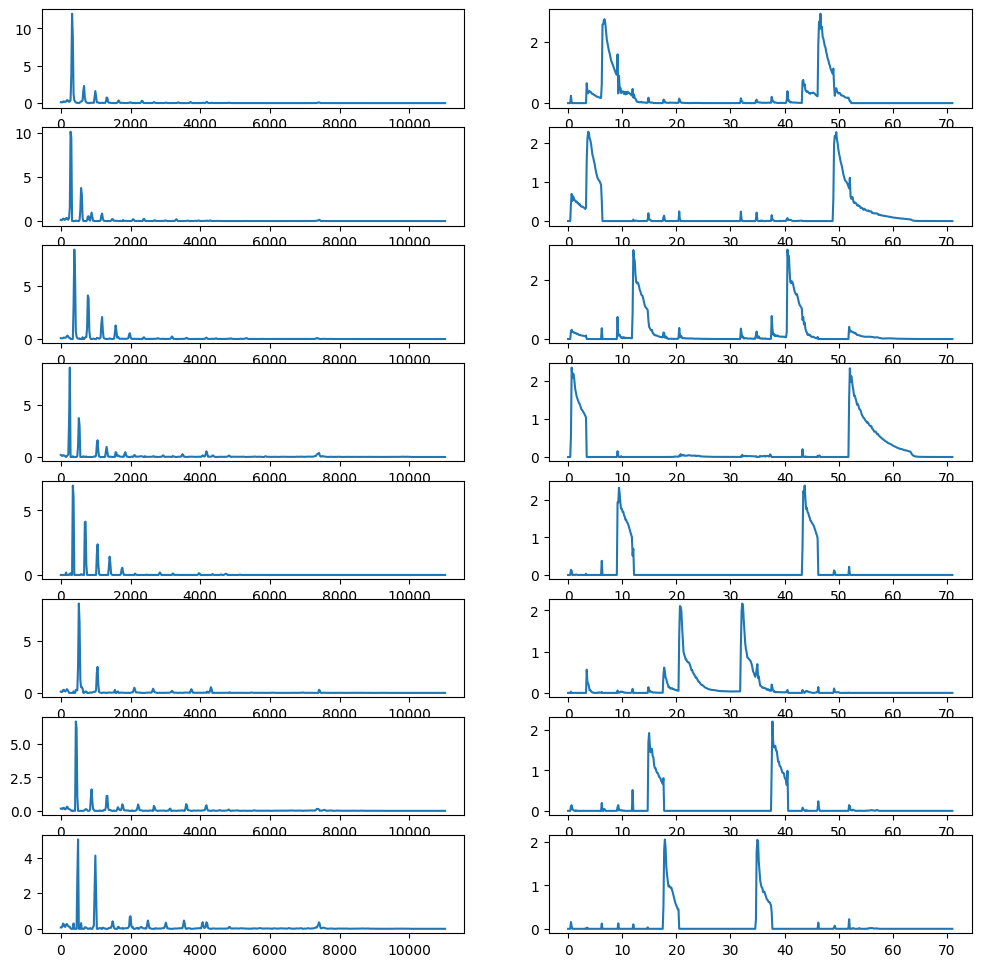

In [7]:
dims = np.shape(magnitude)
rows = dims[0]
cols = dims[1]
f, axs = plt.subplots(channels, 2, figsize=(12,12))
axs[0,0].set_title = "W"
axs[0,1].set_title = "H"
for row in range(channels):
    axs[row,0].plot(np.linspace(0, 11025,rows),W[:,row])
    axs[row,1].plot(np.linspace(0, 71,cols),H[row])
    

In [8]:
sound_lst = []
fils_l = [[0,1,2], [2,4,5,6,7]]
for i in range(2):
    sound_stft_A = np.angle(D)
    filters = fils_l[i]
    filtered = W[:,filters]@H[filters,:]
    reconst = filtered * np.exp(1j*sound_stft_A)
    new_sound = librosa.istft(reconst, n_fft=FRAME1, hop_length=HOP)
    sound_lst.append(new_sound)

In [9]:
i = 3
for sound in sound_lst:
    display(ipd.Audio(sound, rate=sr))
    write(f'../output/{i}.wav', rate = sr, data = sound)
    i += 1

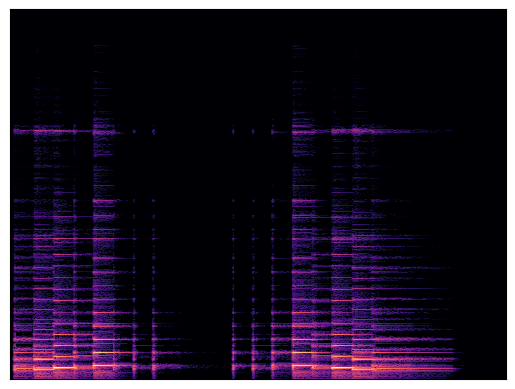

In [10]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(sound_lst[0]))), sr=sr, n_fft=FRAME1, hop_length=HOP)

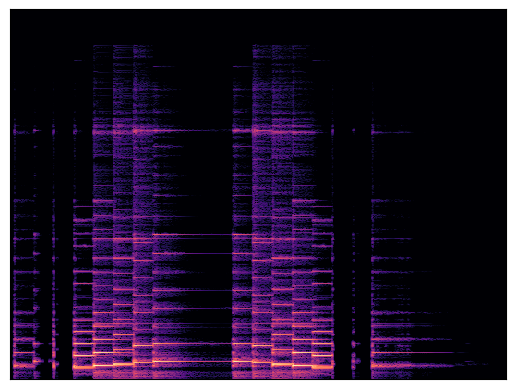

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(sound_lst[1]))), sr=sr, n_fft=FRAME1, hop_length=HOP)

In [12]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def data_getter(channels = 16):
    """Gets data"""
    iters = list(range(100, 1100, 100))
    mse_res = []
    for iter in iters:
        audio_file = "../data/sounds_mixedX.mp3"
        y, _ = librosa.load(audio_file)
        D = librosa.stft(y, n_fft=FRAME1, hop_length=HOP)
        magnitude = np.abs(D) 
        W, H, _ = NMF(magnitude, channels, MAXITER=iter)
        sound_lst = []
        for i in range(2):
            sound_stft_A = np.angle(D)
            filters = list(range(channels))
            filters = [x % 2 == i for x in filters]
            filtered = W[:,filters]@H[filters,:]
            reconst = filtered * np.exp(1j*sound_stft_A)
            new_sound = librosa.istft(reconst, n_fft=FRAME1, hop_length=HOP)
            sound_lst.append(new_sound)
        new_sound = sound_lst[0]
        new_sound = new_sound[:265217]
        new_stft = librosa.stft(new_sound, n_fft=FRAME1, hop_length=HOP)
        audio_file = "../data/sound2.wav"
        x, _ = librosa.load(audio_file)
        MTX = librosa.stft(x, n_fft=FRAME1, hop_length=HOP)
        res = mse(MTX, new_stft)
        mse_res.append(res)
    return iters, mse_res

[80.16882238762128, 65.69627652317317, 58.251524550974004, 53.605910954577446, 50.05588655033485, 46.99139023661875, 44.435139125801506, 42.64828637158054, 41.60805097046823, 41.049205976789025, 40.74394417308941, 40.5680179115878, 40.46131930571442, 40.39379458186389, 40.349225097738525, 40.31850429671679, 40.29650428956924, 40.28027923071669, 40.26801845432347, 40.25853935019423, 40.25105754949396, 40.24504792600957, 40.240149228382556, 40.23610438091486, 40.232725388456785, 40.229872190351685, 40.22743885606516, 40.22534400229399, 40.22352416879357, 40.22192940403274, 40.22052029995207, 40.21926585986753, 40.218141894978885, 40.21712980944945, 40.21621560673933, 40.21538891338653, 40.214641887915256, 40.21396805089766, 40.21336124601601, 40.212814994096306, 40.21232237203553, 40.211876326336125, 40.21147018179637, 40.211098109818565, 40.21075542263177, 40.21043865966429, 40.21014548279893, 40.209874415518804, 40.209624481639764, 40.209394829537096, 40.209184441540096, 40.20899199883

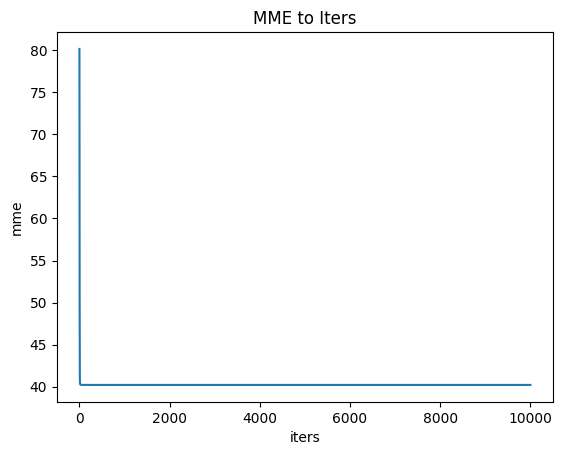

In [13]:
print(cost_func)
plt.plot(list(range(len(cost_func))), cost_func)

# Adding labels and title
plt.xlabel('iters')
plt.ylabel('mme')
plt.title('MME to Iters')

# Display the graph
plt.show()